In [1]:
import numpy as np
import pandas as pd

In [2]:
# https://www.statsmodels.org/stable/index.html
import statsmodels.api as sm

In [3]:
spamDf = pd.read_excel("https://www.dropbox.com/scl/fi/v24mmhg5hmefmnv99uqsy/Spam.xlsx?rlkey=iq7exnueq84sy7y2b8ud70mp0&dl=1")
spamDf

,Record,Spam,Recipients,Hyperlinks,Characters
0,1,0,19,1,47
1,2,0,15,1,58
2,3,1,13,11,88
3,4,1,17,11,68
4,5,0,15,1,87
...,...,...,...,...,...
495,496,0,15,2,97
496,497,0,20,5,72
497,498,1,41,11,52
498,499,1,16,11,74


In [15]:
spamDf.size, spamDf.shape

(2500, (500, 5))

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# Split the dataset into training and testing sets
trainSet, testSet = train_test_split(
  spamDf,
  test_size=0.3,
  random_state=555,
  stratify=spamDf['Spam']
)
trainSet.shape, testSet.shape

((350, 5), (150, 5))

In [18]:
# Fit the logistic regression model
features = ['Recipients', 'Hyperlinks', 'Characters']
xTrain = trainSet[features]
yTrain = trainSet['Spam'].astype(int)

In [19]:
spamBasedOnRecipientsHyperlinksCharactersLogitModel = sm.Logit(
  yTrain,
  sm.add_constant(xTrain)
)
spamBasedOnRecipientsHyperlinksCharactersLogitModelFit = spamBasedOnRecipientsHyperlinksCharactersLogitModel.fit()
print(spamBasedOnRecipientsHyperlinksCharactersLogitModelFit.summary())

Optimization terminated successfully.
         Current function value: 0.454948
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   Spam   No. Observations:                  350
Model:                          Logit   Df Residuals:                      346
Method:                           MLE   Df Model:                            3
Date:                Tue, 18 Jun 2024   Pseudo R-squ.:                  0.3431
Time:                        10:34:59   Log-Likelihood:                -159.23
converged:                       True   LL-Null:                       -242.40
Covariance Type:            nonrobust   LLR p-value:                 7.894e-36
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3891      0.856     -5.129      0.000      -6.066      -2.712
Recipients     0.1408      0.

In [20]:
predict1 = spamBasedOnRecipientsHyperlinksCharactersLogitModelFit.predict(sm.add_constant(testSet[features]))
testSet['predict1'] = predict1
sumTable = pd.DataFrame({'A': testSet['Spam'], 'Prob': testSet['predict1']})
sumTable.to_csv("ROC.csv", index=True)


In [21]:
sumTable

,A,Prob
387,0,0.910903
219,1,0.739589
298,1,0.793527
325,0,0.851853
357,0,0.076918
...,...,...
97,0,0.141878
115,1,0.932888
169,1,0.829097
413,1,0.345374


In [22]:
sumTable1 = pd.DataFrame({'A': testSet['Spam'], 'Prob': testSet['predict1']})

In [23]:
# Make predictions based on probability threshold of 0.5
testSet['predictions'] = (testSet['predict1'] > 0.5).astype(int)
sumTable1['P'] = testSet['predictions']
sumTable1

,A,Prob,P
387,0,0.910903,1
219,1,0.739589,1
298,1,0.793527,1
325,0,0.851853,1
357,0,0.076918,0
...,...,...,...
97,0,0.141878,0
115,1,0.932888,1
169,1,0.829097,1
413,1,0.345374,0


In [25]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve

In [27]:
# Calculate accuracy
accuracy = accuracy_score(sumTable1['A'], sumTable1['P'])
print(f'Accuracy: {accuracy}')

Accuracy: 0.7933333333333333


In [28]:
# Calculate recall
recall = recall_score(sumTable1['A'], sumTable1['P'])
print(f'Recall: {recall}')

Recall: 0.8181818181818182


In [29]:
# Calculate precision
precision = precision_score(sumTable1['A'], sumTable1['P'])
print(f'Precision: {precision}')

Precision: 0.7875


In [30]:
# Sensitivity and Specificity (Sensitivity is same as recall)
sensitivity = recall
specificity = sum((sumTable1['A'] == 0) & (sumTable1['P'] == 0)) / sum(sumTable1['A'] == 0)
print(f'Sensitivity: {sensitivity}')
print(f'Secificity: {specificity}')

Sensitivity: 0.8181818181818182
Secificity: 0.7671232876712328


In [31]:
# Calculate F1 Score
f1Score = 2 * (precision * recall) / (precision + recall)
print(f'F1 Score: {f1Score}')

F1 Score: 0.8025477707006369


In [32]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(testSet['Spam'], testSet['predict1'])
roc_auc = roc_auc_score(testSet['Spam'], testSet['predict1'])
# Calculate AUC
print(f'AUC: {roc_auc}')


AUC: 0.8624799857676569


In [33]:
import matplotlib.pyplot as plt

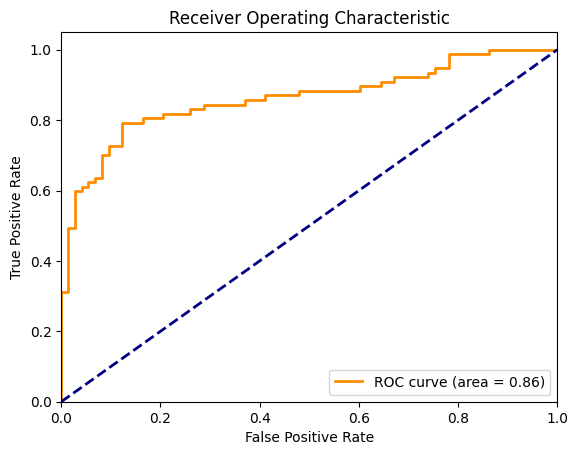

In [34]:

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [35]:
# KFold
from sklearn.model_selection import KFold
# Initialize KFold
# k=2
# k=5
k=10
kf = KFold(n_splits=k, shuffle=True, random_state=555)
spamDf.head()

,Record,Spam,Recipients,Hyperlinks,Characters
0,1,0,19,1,47
1,2,0,15,1,58
2,3,1,13,11,88
3,4,1,17,11,68
4,5,0,15,1,87


In [37]:
check = kf.split(spamDf)
check
experiment = 1
# Loop through each fold
# Initialize variables to store results
accuracies = []

for train_index, val_index in check:
    # Split the data
    trainSet, valSet = spamDf.iloc[train_index], spamDf.iloc[val_index]

    # Fit the model

    trainModel = sm.Logit(
      trainSet["Spam"],
      sm.add_constant(trainSet[['Recipients', 'Hyperlinks', 'Characters']])
    )
    trainModelFit = trainModel.fit()

    # Predict on the validation set
    val_predictions = trainModelFit.predict(sm.add_constant(valSet[['Recipients', 'Hyperlinks', 'Characters']]))
    valSet['val_predictions'] = val_predictions
    valSet['yHatCross'] = valSet['val_predictions'].apply(lambda x: 1 if x > 0.5 else 0)
    valSet['isCrossCorrect'] = valSet.apply(lambda row: 1 if row['Spam'] == row['yHatCross'] else 0, axis=1)
    accuracy = (np.sum(valSet['isCrossCorrect']) / len(valSet['yHatCross'])) * 100
    accuracies.append(accuracy)


    # Print summary for each fold (optional)
    print(f'expr={experiment}')
    experiment = experiment +1
    print(trainModelFit.summary())

Optimization terminated successfully.
         Current function value: 0.455772
         Iterations 6
expr=1
                           Logit Regression Results                           
Dep. Variable:                   Spam   No. Observations:                  450
Model:                          Logit   Df Residuals:                      446
Method:                           MLE   Df Model:                            3
Date:                Tue, 18 Jun 2024   Pseudo R-squ.:                  0.3419
Time:                        10:51:30   Log-Likelihood:                -205.10
converged:                       True   LL-Null:                       -311.63
Covariance Type:            nonrobust   LLR p-value:                 6.322e-46
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7227      0.657     -5.663      0.000      -5.011      -2.434
Recipients     0.1091 

/var/folders/kk/xx0ydj0576xgclh1nd3hdlbr0000gn/T/ipykernel_61311/1702950247.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valSet['val_predictions'] = val_predictions
/var/folders/kk/xx0ydj0576xgclh1nd3hdlbr0000gn/T/ipykernel_61311/1702950247.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valSet['yHatCross'] = valSet['val_predictions'].apply(lambda x: 1 if x > 0.5 else 0)
/var/folders/kk/xx0ydj0576xgclh1nd3hdlbr0000gn/T/ipykernel_61311/1702950247.py:24: SettingWithCopyWarning: 
A value is trying

In [39]:
accuracies, print(f"Average accuracies across all folds: {sum(accuracies) /len(accuracies)}")

Average accuracies across all folds: 79.6


([82.0, 78.0, 74.0, 80.0, 76.0, 84.0, 78.0, 82.0, 80.0, 82.0], None)

In [38]:
accuracies

[82.0, 78.0, 74.0, 80.0, 76.0, 84.0, 78.0, 82.0, 80.0, 82.0]

## Expoprt model

In [40]:
def transformer(df):
    df = df.copy()
    df.insert(0, 'const', 1)
    
    return df

In [41]:
from mlModelSaver import MlModelSaver
mlModelSaverInstance = MlModelSaver({
    "baseRelativePath": "../..",
    "modelsFolder": "models"
})

loadedModel = mlModelSaverInstance.exportModel(
    spamBasedOnRecipientsHyperlinksCharactersLogitModelFit,
    {
        "modelName": "spamBasedOnRecipientsHyperlinksCharactersLogitModelFit",
        "description": "spamBasedOnRecipientsHyperlinksCharactersLogitModelFit",
        "modelType": "sm.Logit",
        "inputs": [
            {
                "name": "Recipients",
                "type": "int",
            },
            {
                "name": "Hyperlinks",
                "type": "int"
            },
            
            {
                "name": "Characters",
                "type": "int"
            }
        ],
        "transformer": transformer,
        "outputs": [
            {
                "name": "Spam",
                "type": "probebility"
            }
        ]
    }
)
loadedModel

In [42]:
testSet['predict2'] = spamBasedOnRecipientsHyperlinksCharactersLogitModelFit.predict(transformer(testSet[features]))
testSet['predict3'] = spamBasedOnRecipientsHyperlinksCharactersLogitModelFit.predict(sm.add_constant(testSet[features]))

In [43]:
testSet.head(5)

,Record,Spam,Recipients,Hyperlinks,Characters,predict1,predictions,predict2,predict3
387,388,0,17,10,70,0.910903,1,0.910903,0.910903
219,220,1,12,8,33,0.739589,1,0.739589,0.739589
298,299,1,12,10,92,0.793527,1,0.793527,0.793527
325,326,0,13,10,71,0.851853,1,0.851853,0.851853
357,358,0,12,2,66,0.076918,0,0.076918,0.076918


In [44]:
testData = [
    {
        "Recipients": 12,
        "Hyperlinks": 8,
        "Characters": 33
    },
    {
        "Recipients": 12,
        "Hyperlinks": 10,
        "Characters": 92
    },
    {
        "Recipients": 13,
        "Hyperlinks": 10,
        "Characters": 71
    },
]

# Create a DataFrame from the dictionary
testDf = pd.DataFrame(testData)

In [45]:
spamBasedOnRecipientsHyperlinksCharactersLogitModelFit.predict( transformer(testDf))

0    0.739589
1    0.793527
2    0.851853
dtype: float64

In [46]:
loadedModel.mlModelSavePredict(testDf)

[{'Spam': 0.7395890361085591},
 {'Spam': 0.7935274978219301},
 {'Spam': 0.85185328295266}]